https://github.com/Rolling-W/MSIT3103Assignments


# MSIT 3103 — Assignment 4 Hotstart Notebook
**Comparative Analysis of Training Methods (5%)**  
**Due:** End of Week 5  
**CLO3:** Compare and evaluate different training methodologies used in generative AI models.

This notebook gives you a simple, compact scaffold so you can **experiment quickly** while keeping your work **well-structured and comparable**. You’ll train the **same tiny generative model** with three methods:

1. **Pre-training (Unsupervised LM)**
2. **Supervised Fine-Tuning (SFT)**
3. **(Bonus) Reinforcement Learning (RL-lite)** — toy REINFORCE with a simple reward

You will:
- Run short training loops on tiny data to **see the dynamics**, not to hit SOTA.
- Use helper utilities to **measure perplexity**, sample generations, and **plot losses**.
- Fill in the **Results & Discussion** cells with your observations.

> ⚠️ The defaults are intentionally tiny (fast, CPU-friendly). Scale up **only if your machine can handle it**.



## 0. Environment Setup (Run Once)
If you are running locally and missing packages, uncomment the `pip` cell below.

- Python ≥ 3.9
- `torch`, `numpy`, `matplotlib`, `tqdm`, `nltk`, `pandas` (optional: `datasets` for WikiText-2)


In [12]:

# If needed, uncomment to install.
%pip install torch numpy matplotlib tqdm nltk pandas datasets --quiet

import math
import os
import random
import time
import json
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd

import nltk
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")


Note: you may need to restart the kernel to use updated packages.



## 1. Config
Tweak these as you experiment. Keep them **small** for faster iterations.


In [13]:

@dataclass
class Config:
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    # data
    use_builtin_tiny_corpus: bool = True  # if False, tries tiny wikitext-2 via datasets
    context_len: int = 64
    train_frac: float = 0.9
    # model
    vocab_size: int = 0  # filled after building tokenizer
    d_model: int = 128
    n_heads: int = 4
    n_layers: int = 2
    dropout: float = 0.1
    # optimization
    batch_size: int = 64
    lr: float = 3e-3
    max_steps_pretrain: int = 1000
    max_steps_sft: int = 1000
    max_steps_rl: int = 200  # tiny on purpose
    eval_every: int = 50
    # generation
    temperature: float = 0.9
    top_k: Optional[int] = 50

CFG = Config()
random.seed(CFG.seed)
np.random.seed(CFG.seed)
torch.manual_seed(CFG.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CFG.seed)

CFG.device


'cuda'


## 2. Data: Tiny Corpus + Optional Synthetic
We use a tiny **public-domain** text for **pre-training** and **validation**.  
For **SFT**, we create a micro instruction-like dataset.

You can switch to `datasets` (WikiText-2) by setting `CFG.use_builtin_tiny_corpus=False`.


In [14]:

BUILTIN_TINY_TEXT = "From fairest creatures we desire increase,\nThat thereby beauty's rose might never die,\nBut as the riper should by time decease,\nHis tender heir might bear his memory:\nBut thou contracted to thine own bright eyes,\nFeed'st thy light'st flame with self-substantial fuel,\nMaking a famine where abundance lies,\nThy self thy foe, to thy sweet self too cruel:"

def load_corpus(use_builtin: bool = True) -> str:
    """Return a small training corpus."""
    if use_builtin:
        return BUILTIN_TINY_TEXT.strip()
    else:
        try:
            from datasets import load_dataset
            ds = load_dataset("wikitext", "wikitext-2-raw-v1")
            # concatenate first N lines to keep it tiny
            lines = ds['train']['text'][:200]
            return "\n".join([l for l in lines if l is not None]).strip()
        except Exception as e:
            print("Falling back to builtin tiny text due to:", e)
            return BUILTIN_TINY_TEXT.strip()

# corpus_text = load_corpus(use_builtin = True)
corpus_text = load_corpus(use_builtin = False)

print(corpus_text[:300], "...")


= Valkyria Chronicles III = 


 Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStat ...



### 2.1 Character Tokenizer
A simple **character-level** tokenizer keeps things very light-weight.


In [15]:

class CharTokenizer:
    def __init__(self, text: str):
        vocab = sorted(set(text))
        self.stoi = {ch: i for i, ch in enumerate(vocab)}
        self.itos = {i: ch for ch, i in self.stoi.items()}
        self.vocab_size = len(vocab)

    def encode(self, s: str) -> List[int]:
        return [self.stoi[c] for c in s if c in self.stoi]

    def decode(self, ids: List[int]) -> str:
        return "".join(self.itos[i] for i in ids)

tokenizer = CharTokenizer(corpus_text)
CFG.vocab_size = tokenizer.vocab_size
print(f"CFG.vocab_size: {CFG.vocab_size}")

# Update the top_k based on vocab size
CFG.top_k = min(50, CFG.vocab_size) # ensure top_k is not greater than vocab_size
print(f"CFG.top_k: {CFG.top_k}")


CFG.vocab_size: 131
CFG.top_k: 50



### 2.2 Dataset & DataLoader
We build tiny (input, target) pairs for next-char prediction.


In [16]:

class LMDataset(Dataset):
    def __init__(self, text: str, tokenizer: CharTokenizer, context_len: int = 64, split: str = "train", train_frac: float = 0.9):
        enc = tokenizer.encode(text)
        n = int(len(enc) * train_frac)
        if split == "train":
            self.data = enc[:n]
        else:
            self.data = enc[n:]
        self.context_len = context_len

    def __len__(self):
        return max(0, len(self.data) - self.context_len - 1)

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.context_len]
        y = self.data[idx+1:idx+self.context_len+1]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

train_ds = LMDataset(corpus_text, tokenizer, CFG.context_len, "train", CFG.train_frac)
val_ds = LMDataset(corpus_text, tokenizer, CFG.context_len, "val", CFG.train_frac)

train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, drop_last=True)

len(train_ds), len(val_ds)


(49757, 5471)


## 3. Model: Tiny GPT-like (Character-level)
Small causal self-attention stack for quick experiments.


In [17]:

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class CausalSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout, context_len):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.qkv = nn.Linear(d_model, 3 * d_model)
        self.proj = nn.Linear(d_model, d_model)
        self.attn_drop = nn.Dropout(dropout)
        self.resid_drop = nn.Dropout(dropout)
        self.register_buffer("mask", torch.tril(torch.ones(context_len, context_len)).unsqueeze(0).unsqueeze(0))

    def forward(self, x):
        B, T, C = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.split(C, dim=2)
        q = q.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)  # (B, nh, T, hs)
        k = k.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v  # (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_drop(self.proj(y))
        return y

class Block(nn.Module):
    def __init__(self, d_model, n_heads, dropout, context_len):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = CausalSelfAttention(d_model, n_heads, dropout, context_len)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, 4*d_model),
            nn.GELU(),
            nn.Linear(4*d_model, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class TinyGPT(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, dropout, context_len):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Parameter(torch.zeros(1, context_len, d_model))
        self.blocks = nn.ModuleList([Block(d_model, n_heads, dropout, context_len) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)

        # init
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        x = self.tok_emb(idx) + self.pos_emb[:, :T, :]
        for blk in self.blocks:
            x = blk(x)
        x = self.ln_f(x)
        logits = self.head(x)  # (B, T, V)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens=128, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -CFG.context_len:]
            logits, _ = self.forward(idx_cond)
            logits = logits[:, -1, :] / max(temperature, 1e-8)
            if top_k is not None:
                v, ix = torch.topk(logits, top_k)
                mask = logits < v[:, [-1]]
                logits[mask] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_id), dim=1)
        return idx



## 4. Utilities: Evaluation & Plotting


In [18]:

def eval_loss(model, loader):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(CFG.device), y.to(CFG.device)
            _, loss = model(x, y)
            losses.append(loss.item())
    model.train()
    return float(np.mean(losses)) if losses else float('nan')

def perplexity(loss_val: float) -> float:
    try:
        return float(math.exp(loss_val))
    except OverflowError:
        return float('inf')

def sample_text(model, prompt: str, max_new_tokens=128):
    model.eval()
    inp = torch.tensor([tokenizer.encode(prompt)], dtype=torch.long, device=CFG.device)
    out = model.generate(inp, max_new_tokens=max_new_tokens, temperature=CFG.temperature, top_k=CFG.top_k)
    return tokenizer.decode(out[0].tolist())

def plot_losses(train_losses, val_losses, title="Training Curves"):
    plt.figure()
    xs = list(range(len(train_losses)))
    plt.plot(xs, train_losses, label="train")
    if val_losses:
        plt.plot(xs, val_losses, label="val")
    plt.title(title)
    plt.xlabel("Eval step (x{} steps)".format(CFG.eval_every))
    plt.ylabel("Loss")
    plt.legend()
    plt.show()



## 5. Pre-training (Unsupervised LM)
Train the tiny GPT on the tiny corpus with next-character prediction.


Pre-training:   0%|          | 0/1000 [00:11<?, ?it/s, loss=1.37, val_loss=1.94]

Pre-train done. Train loss ~ 1.3699339628219604  Val loss ~ 1.9428898769266465  PPL ~ 6.97888999013375


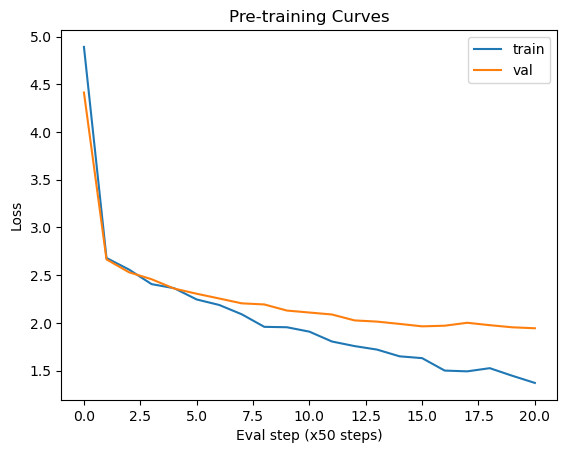

To became and entrating to taton Scholowings Gallian . The majorits the Civil The completion . 


 =


 

 In 191912 , 1862 ,


In [19]:

model_pre = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
opt = torch.optim.AdamW(model_pre.parameters(), lr=CFG.lr)

train_losses_pre, val_losses_pre = [], []
step = 0
pbar = tqdm(total=CFG.max_steps_pretrain, desc="Pre-training")

while step < CFG.max_steps_pretrain:
    for x, y in train_loader:
        x, y = x.to(CFG.device), y.to(CFG.device)
        _, loss = model_pre(x, y)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            vl = eval_loss(model_pre, val_loader)
            train_losses_pre.append(loss.item())
            val_losses_pre.append(vl)
            pbar.set_postfix(loss=loss.item(), val_loss=vl)

        if step >= CFG.max_steps_pretrain:
            break
pbar.close()

pt_train_last = train_losses_pre[-1] if train_losses_pre else float('nan')
pt_val_last = val_losses_pre[-1] if val_losses_pre else float('nan')
print("Pre-train done. Train loss ~", pt_train_last, " Val loss ~", pt_val_last, " PPL ~", perplexity(pt_val_last))
plot_losses(train_losses_pre, val_losses_pre, title="Pre-training Curves")
print(sample_text(model_pre, prompt="To be", max_new_tokens=120))



## 6. Supervised Fine-Tuning (SFT)
We create a **tiny instruction-like dataset** of (prompt → completion).  
We then **continue training** the pre-trained model on these pairs (next-token loss).

> Tip: Replace `SFT_PAIRS` with your own pairs to study transfer.


Instruction: Write a short motto about learning:
Answer: Learn, iterate, and grow.

Instruction: Summarize: 'Neural nets learn patterns'.
Answer: They learn patterns by adjusting weights.

Instruction: Give a creative tagline for coffee:
Answer: Sip ideas. Brew brilliance.

Instruction: Explain: What is perplexity (1 sentence)?
Answer: A measure of how well a language model predicts a sample.




SFT:   0%|          | 0/1000 [00:07<?, ?it/s, loss=0.0527, val_loss=nan]

SFT done. Train loss ~ 0.05272906273603439  Val loss ~ nan  PPL ~ nan


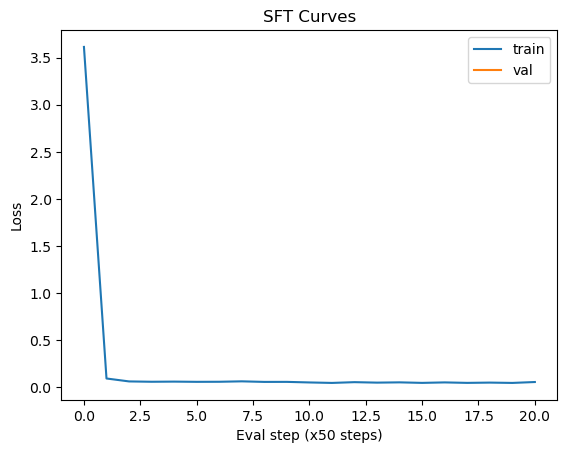

Sample before SFT (pretrained):
Instruction: Give a creative tagline for coffee:
Answer: the Confederate Venial Rock Arsenal in that the Valkyria Chronicles III ( 戦場のヴァルキュリア３ Vo女 Valkyria siles . On Ane and i

Sample after SFT:
Instruction: Give a creative tagline for coffee:
Answer: Sip ideas. Brew brilliance.

Instruction: Explain: What is perplexity (1 sentence)
Answer: A measure of how w w weights


In [20]:

SFT_PAIRS = [
    ("Write a short motto about learning:", " Learn, iterate, and grow."),
    ("Summarize: 'Neural nets learn patterns'.", " They learn patterns by adjusting weights."),
    ("Give a creative tagline for coffee:", " Sip ideas. Brew brilliance."),
    ("Explain: What is perplexity (1 sentence)?", " A measure of how well a language model predicts a sample."),
]

def build_sft_text(pairs: List[Tuple[str, str]]) -> str:
    # Concatenate as instruction blocks to make conditional LM easy
    blocks = []
    for inp, out in pairs:
        blocks.append(f"Instruction: {inp}\nAnswer:{out}\n\n")
    return "".join(blocks)

sft_text = build_sft_text(SFT_PAIRS)
print(sft_text)

# Build tiny SFT dataset as LM on the concatenated text
sft_train_ds = LMDataset(sft_text, tokenizer, CFG.context_len, "train", 0.9)
sft_val_ds = LMDataset(sft_text, tokenizer, CFG.context_len, "val", 0.9)
sft_train_loader = DataLoader(sft_train_ds, batch_size=CFG.batch_size, shuffle=True, drop_last=True)
sft_val_loader = DataLoader(sft_val_ds, batch_size=CFG.batch_size, shuffle=False, drop_last=True)

# Copy the pre-trained model weights
model_sft = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
model_sft.load_state_dict(model_pre.state_dict())
opt_sft = torch.optim.AdamW(model_sft.parameters(), lr=CFG.lr)

train_losses_sft, val_losses_sft = [], []
step = 0
pbar = tqdm(total=CFG.max_steps_sft, desc="SFT")

while step < CFG.max_steps_sft:
    for x, y in sft_train_loader:
        x, y = x.to(CFG.device), y.to(CFG.device)
        _, loss = model_sft(x, y)
        opt_sft.zero_grad(set_to_none=True)
        loss.backward()
        opt_sft.step()
        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            vl = eval_loss(model_sft, sft_val_loader)
            train_losses_sft.append(loss.item())
            val_losses_sft.append(vl)
            pbar.set_postfix(loss=loss.item(), val_loss=vl)

        if step >= CFG.max_steps_sft:
            break
pbar.close()

sft_train_last = train_losses_sft[-1] if train_losses_sft else float('nan')
sft_val_last = val_losses_sft[-1] if val_losses_sft else float('nan')
print("SFT done. Train loss ~", sft_train_last, " Val loss ~", sft_val_last, " PPL ~", perplexity(sft_val_last))
plot_losses(train_losses_sft, val_losses_sft, title="SFT Curves")

print("Sample before SFT (pretrained):")
print(sample_text(model_pre, prompt="Instruction: Give a creative tagline for coffee:\nAnswer:", max_new_tokens=120))

print("\nSample after SFT:")
print(sample_text(model_sft, prompt="Instruction: Give a creative tagline for coffee:\nAnswer:", max_new_tokens=120))


# Report Questions (Answer in your 2–5 page PDF)

### 1. Introduction (Objectives & Rationale)
1. What training methods are you comparing in this assignment?  
2. Why did you choose these methods and settings?  
3. Were there any hardware or time constraints that influenced your choices?  

### 2. Methods
4. What dataset did you use (corpus size, preprocessing steps, train/validation split)?  
5. What is the architecture of your model (layers, hidden size, heads, parameters)?  
6. How did you train your models (steps, batch size, learning rate, optimizer)?  
7. For SFT: How did you construct or curate your instruction–answer pairs?  
8. For RL-lite: What reward function did you design and why?  

### 3. Results
9. What do your loss curves show for pre-training vs. SFT?  
10. How do the perplexity scores compare across methods?  
11. How do BLEU scores differ for the instruction prompts?  
12. How do sample outputs change before SFT, after SFT, and after RL-lite? Provide examples.  

### 4. Discussion
13. How stable was the training process (convergence, fluctuations, instabilities)?  
14. What transfer effects did you observe from pre-training to SFT?  
15. What were the strengths and weaknesses of your RL-lite approach?  
16. What were the main costs in terms of resources and time? If you scaled up, what would you change next?  

### 5. Conclusion
17. What are your key insights from comparing these training methods?  
18. What practical recommendations would you make for someone building generative AI models based on your experiments?  

## [Bonus] RL-lite with REINFORCE (Optional)
**Toy** example: optimize the model to include a **keyword** in the completion and keep length near a **target**.



Baseline (SFT) metrics: {'keyword_hit_rate': 0.5, 'avg_completion_len': 80.0, 'avg_rep_penalty': 0.0}


RL-lite (REINFORCE):   0%|          | 0/200 [00:00<?, ?it/s]

step=   1 | reward=2.193 | hit=1 | len= 27 | rep_pen=0.000 | baseline=2.193 | lm_loss=0.043

RL-lite (REINFORCE):   0%|          | 1/200 [00:00<00:39,  4.99it/s]

RL-lite (REINFORCE):  25%|██▌       | 50/200 [00:13<00:38,  3.89it/s]

step=  50 | reward=0.200 | hit=0 | len= 28 | rep_pen=0.000 | baseline=1.803 | lm_loss=0.142


RL-lite (REINFORCE):  50%|█████     | 100/200 [00:26<00:26,  3.81it/s]

step= 100 | reward=2.200 | hit=1 | len= 28 | rep_pen=0.000 | baseline=1.940 | lm_loss=0.065


RL-lite (REINFORCE):  75%|███████▌  | 150/200 [00:39<00:11,  4.36it/s]

step= 150 | reward=2.200 | hit=1 | len= 28 | rep_pen=0.000 | baseline=2.022 | lm_loss=0.087


RL-lite (REINFORCE): 100%|██████████| 200/200 [00:50<00:00,  3.97it/s]

step= 200 | reward=2.229 | hit=1 | len= 32 | rep_pen=0.000 | baseline=2.177 | lm_loss=0.121



After RL-lite metrics: {'keyword_hit_rate': 1.0, 'avg_completion_len': 80.0, 'avg_rep_penalty': 0.0}
Keyword hit rate: 0.500 -> 1.000 | Avg length: 80.0 -> 80.0 | Rep penalty: 0.000 -> 0.000


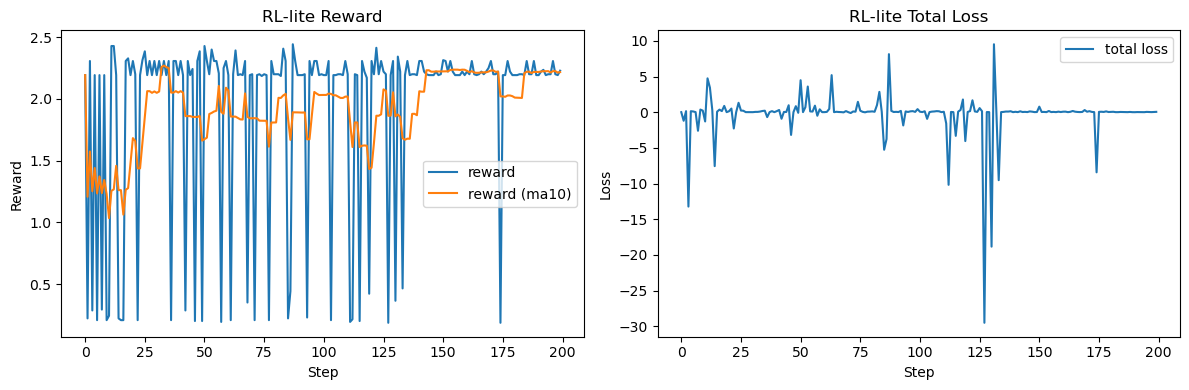


Sample generations before vs after RL-lite:

Prompt 1: Instruction: Write a short motto about learning:
Answer:
Before (SFT):  Learn, iterate, and grow.

Instruction: Summarize: 'Neural nets learn patterns'
After (RL-lite):       Learn, iterate, and grow.

Instruction: Summarize: 'Neural nets learn patterns'

Prompt 2: Instruction: Summarize: 'Neural nets learn patterns'.
Answer:
Before (SFT):  They learn patterns by adjusting weights.

Instruction: Give a creative tagline
After (RL-lite):       They learn patterns by adjusting weights.

Instruction: Give a creative tagline

Prompt 3: Instruction: Give a creative tagline for coffee:
Answer:
Before (SFT):  Sip ideas. Brew brilliance.

Instruction: Explain: What is perplexity (1 senten
After (RL-lite):       Sip ideasure of how learning:
Answer: Learn, iterate, and grow.

Instruction: S


In [21]:
# --- RL-lite with REINFORCE (toy, stabilized) ---
if "model_sft" in globals():
    base_model = model_sft
    base_model_name = "SFT"
elif "model_pre" in globals():
    base_model = model_pre
    base_model_name = "Pretrained"
else:
    raise RuntimeError("Please run pre-training (and preferably SFT) cells first.")

if "SFT_PAIRS" in globals() and len(SFT_PAIRS) > 0:
    RL_PROMPTS = [f"Instruction: {inp}\nAnswer:" for inp, _ in SFT_PAIRS]
else:
    RL_PROMPTS = [
        "Instruction: Write a short motto about learning:\nAnswer:",
        "Instruction: Give a creative tagline for coffee:\nAnswer:",
        "Instruction: Explain perplexity in one sentence:\nAnswer:",
    ]

RL_KEYWORD = "learn"
TARGET_LEN = 70
MAX_NEW_TOKENS = 80
rl_lr = CFG.lr * 0.05

# Added for stabilization
entropy_coef = 0.003      # encourage exploration
anchor_coef = 0.4         # keep model close to language quality
use_anchor_text = True

def safe_text_for_vocab(text: str) -> str:
    filtered = "".join([c for c in text if c in tokenizer.stoi])
    return filtered if filtered else tokenizer.itos[0]

rl_keyword = safe_text_for_vocab(RL_KEYWORD.lower())

def encode_prompt(prompt: str):
    prompt = safe_text_for_vocab(prompt)
    ids = tokenizer.encode(prompt)
    if len(ids) == 0:
        ids = [0]
    return torch.tensor([ids], dtype=torch.long, device=CFG.device)

def sample_completion_with_logprob(
    model,
    prompt: str,
    max_new_tokens: int,
    temperature: float = 1.0,
    top_k: Optional[int] = None,
    stop_char: str = "\n",
):
    model.train()
    idx = encode_prompt(prompt)
    sampled_ids, log_probs, entropies = [], [], []

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -CFG.context_len:]
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :] / max(temperature, 1e-8)

        if top_k is not None:
            k = min(int(top_k), logits.size(-1))
            v, _ = torch.topk(logits, k)
            logits[logits < v[:, [-1]]] = -float("inf")

        probs = F.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs=probs)
        next_id = dist.sample()
        log_probs.append(dist.log_prob(next_id).squeeze(0))
        entropies.append(dist.entropy().squeeze(0))

        next_token_id = int(next_id.item())
        sampled_ids.append(next_token_id)
        idx = torch.cat([idx, next_id.unsqueeze(1)], dim=1)

        if tokenizer.itos[next_token_id] == stop_char and len(sampled_ids) > 12:
            break

    completion = tokenizer.decode(sampled_ids) if sampled_ids else ""
    logprob_sum = torch.stack(log_probs).sum() if log_probs else torch.tensor(0.0, device=CFG.device)
    entropy_sum = torch.stack(entropies).sum() if entropies else torch.tensor(0.0, device=CFG.device)
    return completion, logprob_sum, entropy_sum

def repetition_penalty(text: str) -> float:
    if len(text) <= 1:
        return 0.0
    counts = {}
    for ch in text:
        counts[ch] = counts.get(ch, 0) + 1
    max_repeat_ratio = max(counts.values()) / len(text)
    # Penalize heavy repetition (e.g., 'llllllll...')
    return max(0.0, max_repeat_ratio - 0.35)

def reward_fn(completion: str, keyword: str, target_len: int):
    comp = completion.lower()
    hit = 1.0 if (keyword and keyword in comp) else 0.0
    len_score = 1.0 - min(abs(len(completion) - target_len) / max(target_len, 1), 1.0)
    rep_pen = repetition_penalty(completion)
    reward = 2.0 * hit + 0.5 * len_score - 2.0 * rep_pen
    return reward, hit, len(completion), rep_pen

@torch.no_grad()
def evaluate_keyword_and_length(model, prompts, keyword, target_len, max_new_tokens=80):
    model.eval()
    hits, lengths, rep_pens = [], [], []
    for prompt in prompts:
        inp = encode_prompt(prompt)
        out = model.generate(
            inp,
            max_new_tokens=max_new_tokens,
            temperature=CFG.temperature,
            top_k=CFG.top_k,
        )
        new_ids = out[0, inp.size(1):].tolist()
        completion = tokenizer.decode(new_ids)
        _, hit, comp_len, rep_pen = reward_fn(completion, keyword, target_len)
        hits.append(hit)
        lengths.append(comp_len)
        rep_pens.append(rep_pen)

    return {
        "keyword_hit_rate": float(np.mean(hits)) if hits else float("nan"),
        "avg_completion_len": float(np.mean(lengths)) if lengths else float("nan"),
        "avg_rep_penalty": float(np.mean(rep_pens)) if rep_pens else float("nan"),
    }

def random_anchor_batch(text_source: str, batch_size: int, context_len: int):
    clean = tokenizer.encode(safe_text_for_vocab(text_source))
    if len(clean) < context_len + 2:
        x = torch.zeros((batch_size, context_len), dtype=torch.long, device=CFG.device)
        y = torch.zeros((batch_size, context_len), dtype=torch.long, device=CFG.device)
        return x, y

    xs, ys = [], []
    max_start = len(clean) - context_len - 1
    for _ in range(batch_size):
        s = random.randint(0, max_start)
        x_ids = clean[s:s+context_len]
        y_ids = clean[s+1:s+context_len+1]
        xs.append(x_ids)
        ys.append(y_ids)

    x = torch.tensor(xs, dtype=torch.long, device=CFG.device)
    y = torch.tensor(ys, dtype=torch.long, device=CFG.device)
    return x, y

anchor_text = sft_text if (use_anchor_text and "sft_text" in globals()) else corpus_text

model_rl = TinyGPT(
    CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len
).to(CFG.device)
model_rl.load_state_dict(base_model.state_dict())
opt_rl = torch.optim.AdamW(model_rl.parameters(), lr=rl_lr)

metrics_before = evaluate_keyword_and_length(
    base_model, RL_PROMPTS, rl_keyword, TARGET_LEN, max_new_tokens=MAX_NEW_TOKENS
)
print(f"Baseline ({base_model_name}) metrics:", metrics_before)

rl_rewards, rl_losses, rl_hits = [], [], []
ema_baseline = 0.0

for step in tqdm(range(1, CFG.max_steps_rl + 1), desc="RL-lite (REINFORCE)"):
    prompt = random.choice(RL_PROMPTS)
    completion, logprob_sum, entropy_sum = sample_completion_with_logprob(
        model_rl,
        prompt=prompt,
        max_new_tokens=MAX_NEW_TOKENS,
        temperature=CFG.temperature,
        top_k=CFG.top_k,
    )

    reward, hit, comp_len, rep_pen = reward_fn(completion, rl_keyword, TARGET_LEN)
    ema_baseline = reward if step == 1 else (0.95 * ema_baseline + 0.05 * reward)
    advantage = reward - ema_baseline

    policy_loss = -advantage * logprob_sum - entropy_coef * entropy_sum

    if anchor_coef > 0.0:
        x_anchor, y_anchor = random_anchor_batch(anchor_text, batch_size=8, context_len=CFG.context_len)
        _, lm_loss = model_rl(x_anchor, y_anchor)
        total_loss = policy_loss + anchor_coef * lm_loss
    else:
        lm_loss = torch.tensor(0.0, device=CFG.device)
        total_loss = policy_loss

    opt_rl.zero_grad(set_to_none=True)
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model_rl.parameters(), max_norm=1.0)
    opt_rl.step()

    rl_rewards.append(float(reward))
    rl_losses.append(float(total_loss.item()))
    rl_hits.append(float(hit))

    if step % CFG.eval_every == 0 or step == 1:
        print(
            f"step={step:4d} | reward={reward:.3f} | hit={hit:.0f} | len={comp_len:3d} | "
            f"rep_pen={rep_pen:.3f} | baseline={ema_baseline:.3f} | lm_loss={float(lm_loss.item()):.3f}"
        )

metrics_after = evaluate_keyword_and_length(
    model_rl, RL_PROMPTS, rl_keyword, TARGET_LEN, max_new_tokens=MAX_NEW_TOKENS
)

print("\nAfter RL-lite metrics:", metrics_after)
print(
    f"Keyword hit rate: {metrics_before['keyword_hit_rate']:.3f} -> {metrics_after['keyword_hit_rate']:.3f} | "
    f"Avg length: {metrics_before['avg_completion_len']:.1f} -> {metrics_after['avg_completion_len']:.1f} | "
    f"Rep penalty: {metrics_before['avg_rep_penalty']:.3f} -> {metrics_after['avg_rep_penalty']:.3f}"
)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(rl_rewards, label="reward")
plt.plot(pd.Series(rl_rewards).rolling(10, min_periods=1).mean(), label="reward (ma10)")
plt.title("RL-lite Reward")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rl_losses, label="total loss")
plt.title("RL-lite Total Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

print("\nSample generations before vs after RL-lite:")
for i, prompt in enumerate(RL_PROMPTS[:3], start=1):
    base_inp = encode_prompt(prompt)
    base_out = base_model.generate(
        base_inp,
        max_new_tokens=MAX_NEW_TOKENS,
        temperature=CFG.temperature,
        top_k=CFG.top_k,
    )
    base_comp = tokenizer.decode(base_out[0, base_inp.size(1):].tolist())

    rl_inp = encode_prompt(prompt)
    rl_out = model_rl.generate(
        rl_inp,
        max_new_tokens=MAX_NEW_TOKENS,
        temperature=CFG.temperature,
        top_k=CFG.top_k,
    )
    rl_comp = tokenizer.decode(rl_out[0, rl_inp.size(1):].tolist())

    print(f"\nPrompt {i}: {prompt}")
    print(f"Before ({base_model_name}): {base_comp}")
    print(f"After (RL-lite):      {rl_comp}")

In [22]:
# Optional metric: BLEU comparison on SFT prompts
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def completion_only(model, prompt, max_new_tokens=80):
    prompt_ids = encode_prompt(prompt)
    out = model.generate(
        prompt_ids,
        max_new_tokens=max_new_tokens,
        temperature=CFG.temperature,
        top_k=CFG.top_k,
    )
    new_ids = out[0, prompt_ids.size(1):].tolist()
    return tokenizer.decode(new_ids)

def calc_bleu_for_model(model, pairs):
    smoothie = SmoothingFunction().method1
    scores = []
    for inp, ref in pairs:
        prompt = f"Instruction: {inp}\nAnswer:"
        hyp = completion_only(model, prompt, max_new_tokens=MAX_NEW_TOKENS).strip()
        ref_tokens = [ref.strip().split()]
        hyp_tokens = hyp.split() if hyp else [""]
        score = sentence_bleu(ref_tokens, hyp_tokens, smoothing_function=smoothie)
        scores.append(score)
    return float(np.mean(scores)) if scores else float("nan")

bleu_pre = calc_bleu_for_model(model_pre, SFT_PAIRS) if "model_pre" in globals() else float("nan")
bleu_sft = calc_bleu_for_model(model_sft, SFT_PAIRS) if "model_sft" in globals() else float("nan")
bleu_rl = calc_bleu_for_model(model_rl, SFT_PAIRS) if "model_rl" in globals() else float("nan")

print({
    "BLEU_pretrained": bleu_pre,
    "BLEU_sft": bleu_sft,
    "BLEU_rl_lite": bleu_rl,
})

{'BLEU_pretrained': 0.002700578722727016, 'BLEU_sft': 0.2881091093523539, 'BLEU_rl_lite': 0.2383667685036024}



## Submission Checklist
- [ ] Notebook runs end-to-end (or with clear notes where you modified).
- [ ] 2–5 page PDF report with figures & tables.
- [ ] Upload files to Canvas: **PDF + .ipynb** (include your GitHub link).

